# Разметка данных. Кластеризация

### Импорт библиотек
* pandas - для работы с таблицей данных
* numpy - для работы с массивами
* nltk, pymorphy - для предобработки запросов
* sklearn - модели векторизаторов и кластеризаторов
* normalize - собственный модуль для нормализации текста
* pickle - сериализация и десериализация данных, необходим для сохранения весов модели

In [1]:
# Спрятать warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymorphy2 import MorphAnalyzer
import numpy as np
import pandas as pd
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

# Для нормализации текста
from normalize import normalize_text

nltk.download('punkt')
nltk.download('stopwords')
# морфологический анализатор для русского языка
morph = MorphAnalyzer()

[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка данных

### Считывание данных

In [3]:
df = pd.read_csv('../data/data.csv')
print(df.head())

   Unnamed: 0                                   query  col1  col2  col3
0           0   имеются ли у вас номера бизнес класса    98    16    48
1           1         Добрый день Какое время заезда     70    85    40
2           2            скажите номера какие имеются    88    49    94
3           3               когда можно будет заехать    46    30    35
4           4  какие услуги гостинице есть дополнение    26    16    37


### Выбираем только нужные столбцы, переименуем для более удобного обращения и удалим поля с пустыми значениями

In [4]:
df = df[['query']]
df.columns = ['text']
df = df.dropna()
df.text

0                  имеются ли у вас номера бизнес класса
1                        Добрый день Какое время заезда 
2                           скажите номера какие имеются
3                              когда можно будет заехать
4                 какие услуги гостинице есть дополнение
                             ...                        
488         Здравствуйте Мне нужно оформить бронь номера
489             Здравствуйте где я смогу оставить машину
490            хочу узнать какие есть услуги в гостинице
491                    во сколько можно въезжать в номер
492    добрый день у вас в гостинице есть дополнитель...
Name: text, Length: 493, dtype: object

### Нормализация текста

**Нормализация текста** - процесс приведения текста к нормальному виду, то есть каждый токен в предложении будет заменен на его нормальную форму.
Производится в файле `normalize.py`

In [5]:
# нормализация каждой строки из таблицы
df["normal_text"] = [normalize_text(text, stop_words=True) for text in df.text]

print(df.normal_text)

print(df.head())

0                       иметься номер бизнес класс
1                    добрый день какой время заезд
2                      сказать номер какой иметься
3                                          заехать
4                какой услуга гостиница дополнение
                          ...                     
488        здравствуйте нужно оформить бронь номер
489             здравствуйте смочь оставить машина
490           хотеть узнать какой услуга гостиница
491                         сколько въезжать номер
492    добрый день гостиница дополнительный услуга
Name: normal_text, Length: 493, dtype: object
                                     text                        normal_text
0   имеются ли у вас номера бизнес класса         иметься номер бизнес класс
1         Добрый день Какое время заезда       добрый день какой время заезд
2            скажите номера какие имеются        сказать номер какой иметься
3               когда можно будет заехать                            заехать
4  какие

## Векторное представление

**Представление запросов в виде векторов**

В больших наборах текстовых данных некоторые слова будут встречаться в большом количестве текстов и следовательно нести мало значимой информации о них. Чтобы снизить значимость частотных слов и увеличить ее для редких слов, применяют $tf\times idf$ векторизатор.

**TF (term frequency)** - частота слова - доля конкретного слова ($q$) среди всех слов ($t$) документа ($D$)
$$
TF = \frac{f(q,D)}{f(t,D)}
$$
где $f(q, D)$ - частота конкретного слова в рамках текущего документа, $f(t, D)$ - частота всех слов в рамках текущего документа.

**IDF (inverted document frequency)**  - обратная частота документа, показывает насколько часто встречается слово во всех документах $N$.
$$
IDF = log\frac{N}{N(q)}
$$
где $N$ - число всех документов, $N(q)$ - число документов, где встречается $q$.

На практике используется обычно используется формула со сглаживанием
$$
IDF = log\frac{N+1}{N(q)+1}
$$

In [6]:
# TfidfVectorizer() работает следующим образом:
# 1. преобразует запросы с помощью CountVectorizer() - который суммирует one-hot эмбеддинги всех слов запроса
# 2. трансформирует полученные эмбеддинги, применяя tf*idf

# Векторизуем запросы
vectorizer = TfidfVectorizer()
text_embeddings = vectorizer.fit_transform(df.text)

print(text_embeddings)

  (0, 216)	0.5515966319757116
  (0, 27)	0.588237523357035
  (0, 281)	0.24730233318637215
  (0, 42)	0.21899782489468475
  (0, 236)	0.25488249799458845
  (0, 193)	0.4190873329222027
  (1, 156)	0.5979360947422233
  (1, 66)	0.40567211121447183
  (1, 213)	0.48076590887318327
  (1, 113)	0.3546095083077022
  (1, 122)	0.3478775679320583
  (2, 205)	0.3932960485716564
  (2, 423)	0.5399095973063889
  (2, 281)	0.3782045989833705
  (2, 193)	0.6409189700907614
  (3, 160)	0.5435688724373403
  (3, 33)	0.5619301985519987
  (3, 263)	0.40990725209622914
  (3, 218)	0.46983335082923644
  (4, 127)	0.7389664088338584
  (4, 141)	0.2566637546352791
  (4, 90)	0.3880614661285268
  (4, 478)	0.3648125548889403
  (4, 205)	0.3230672715910641
  (5, 322)	0.23276749012084288
  :	:
  (488, 180)	0.24808902753679482
  (488, 281)	0.27134782766639537
  (489, 245)	0.4987987935591639
  (489, 316)	0.4987987935591639
  (489, 86)	0.4825391501566676
  (489, 431)	0.46879181754105065
  (489, 180)	0.2231361186820377
  (490, 472)	0.5

## Кластеризация
Векторы готовы, теперь можем приступить к кластеризации. Мы рассмотрим использование алгоритма K-средних, он отлично подходит тогда, когда заранее известно число кластеров.

Алгоритм KMeans
* Шаг 1.
Выбор k случайных точек на плоскости - центры кластеров.
* Шаг 2.
Поиск ближайшей точки к каждому центру.
* Шаг 3.
Вычисление нового центра - среднее меду точками кластера. Возврат на шаг 2.

Алгоритм MiniBatchKMeans 

Отличается от K-means тем, что на шаге 2 происходит поиск не одной, а нескольких ближайших точек к каждому кластеру.
Обычно применяется, если выборка очень большая (стандартный алгоритм будет медленным)

In [7]:
# Метод KMeans
def cluster_kmeans(num_clusters, embeddings, init='k-means++', random_state=42):
    clustering_model = KMeans(n_clusters=num_clusters, init=init, n_init=100, random_state=random_state)
    clusters = clustering_model.fit_predict(embeddings)
    return clusters

# Метод MiniBatchKMeans
def cluster_miniBatchKMeans(num_clusters, embeddings, init_size=16, batch_size=16, random_state=42):
    clustering_model = MiniBatchKMeans(n_clusters=num_clusters, init_size=init_size, batch_size=batch_size,
                                       random_state=random_state)
    clusters = clustering_model.fit_predict(embeddings)
    return clusters

# Число кластеров
num_clusters = 5
print("Число кластеров:", num_clusters)

kmeans = cluster_kmeans(num_clusters, text_embeddings)

miniBatchKMeans = cluster_miniBatchKMeans(num_clusters, text_embeddings)

print("\nKMeans\n", kmeans)
print("\nminiBatchKMeans\n", miniBatchKMeans)

Число кластеров: 5

KMeans
 [0 4 0 4 3 4 4 1 1 3 0 0 4 2 4 4 4 4 1 1 4 4 3 1 4 4 4 3 4 4 4 1 1 4 1 4 0
 4 4 4 0 4 4 4 3 0 0 4 4 4 0 1 4 4 4 1 2 0 4 3 3 0 4 4 4 2 1 0 4 4 1 3 4 4
 1 0 4 4 4 4 0 1 4 2 0 0 2 4 0 0 4 4 1 3 2 1 3 0 0 2 0 0 0 4 2 2 1 1 4 2 0
 4 4 3 1 4 1 3 3 4 2 4 0 4 4 4 4 4 4 3 4 2 4 4 0 0 3 4 4 1 4 3 1 4 0 1 4 4
 3 4 4 4 4 4 4 1 1 0 4 1 4 3 4 4 4 4 2 4 0 1 3 2 2 0 4 2 4 4 0 4 1 1 4 0 1
 2 2 4 1 2 4 4 4 4 2 4 1 4 4 4 2 4 1 4 4 4 1 2 0 3 4 4 4 2 4 3 3 2 4 4 2 3
 4 4 4 0 0 4 0 2 0 0 2 4 3 4 2 2 4 1 4 4 0 3 4 2 0 2 0 2 4 2 4 0 1 4 4 2 1
 4 4 1 2 4 4 0 4 1 4 4 1 4 4 1 3 1 0 4 1 4 4 2 3 4 4 2 4 4 0 4 1 2 4 2 1 4
 0 0 4 2 3 1 4 4 0 4 3 2 4 4 4 2 4 1 1 4 1 4 3 3 4 4 4 4 1 2 4 1 1 4 0 4 3
 2 2 4 0 3 4 4 4 0 4 4 4 3 4 4 0 4 4 1 4 3 4 4 4 4 3 4 1 4 4 4 4 4 2 4 3 4
 0 0 4 4 1 3 4 0 4 3 0 1 4 3 4 4 2 2 0 3 2 1 3 4 0 4 0 3 4 0 4 4 4 4 2 1 2
 1 2 4 4 4 0 1 4 0 2 3 4 3 2 4 4 4 4 4 1 4 1 4 0 0 0 4 4 4 4 4 4 0 1 4 4 1
 4 4 4 4 4 4 4 2 0 2 2 2 4 4 2 3 2 0 0 4 3 3 4 0 4 1 4 4 4 4 0 4 4 4 4 4

# Визуализация
Алгоритм ниже выполняет снижение размерности и вывод векторов на плоскость

In [8]:
# импорт библиотек для визулизации кластеров
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_tsne_pca(embeddings, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(embeddings.shape[0]), size=100, replace=False)

    pca = PCA(n_components=2).fit_transform(embeddings[max_items, :].todense())
    tsne = TSNE(perplexity=15).fit_transform(PCA(n_components=20).fit_transform(embeddings[max_items, :].todense()))

    idx = np.random.choice(range(pca.shape[0]), size=100, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i / max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA')

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE')

    f.show()
    #plt.show()

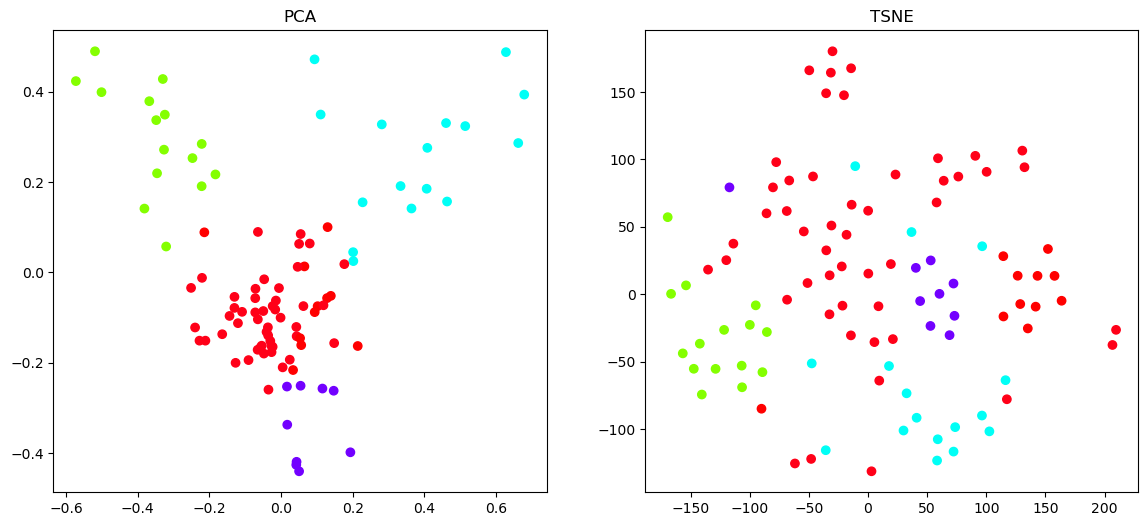

In [9]:
# визуализация результатов KMeans
plot_tsne_pca(text_embeddings, kmeans)

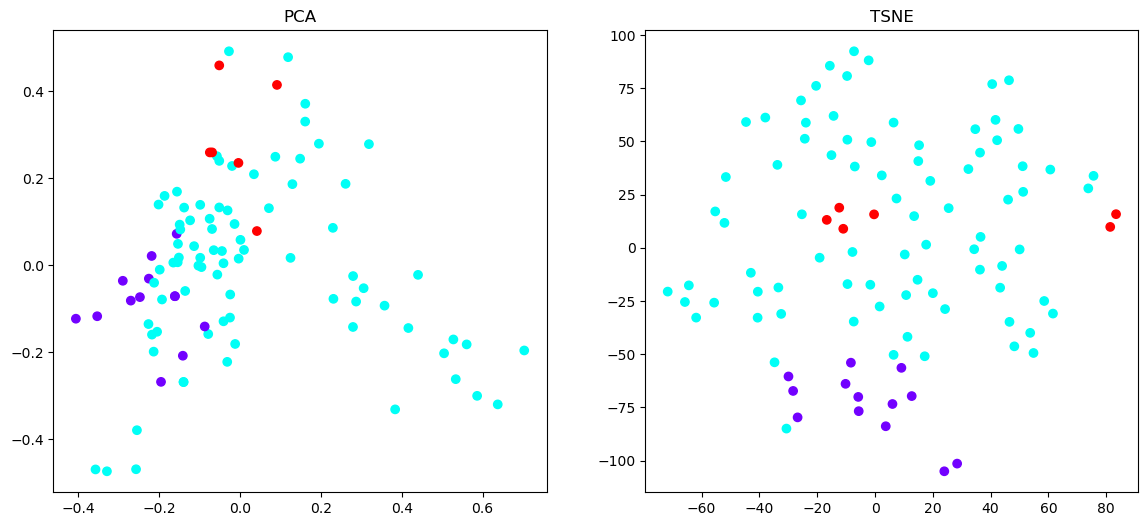

In [10]:
# визуализация результатов MiniBatchKMeans
plot_tsne_pca(text_embeddings, miniBatchKMeans)

На наших данных лучший результат показал KMeans

# Размеченный датасет

Получим самые частотные слова в каждом кластере - они и послужат названиями классов

In [11]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    top_keywords = []
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        l = [labels[t] for t in np.argsort(r)[-n_terms:]]
        l.sort()
        print(','.join(l))
        top_keywords.append(','.join(l))
    return top_keywords


top_words = 1
cluster_names_km = get_top_keywords(text_embeddings, kmeans, vectorizer.get_feature_names(), top_words)
print("\nKMeans\n", cluster_names_km)
cluster_names_bkm = get_top_keywords(text_embeddings, miniBatchKMeans, vectorizer.get_feature_names(), top_words)
print("\nminiBatchKMeans\n", cluster_names_bkm)



Cluster 0
номера

Cluster 1
забронировать

Cluster 2
парковка

Cluster 3
услуги

Cluster 4
время

KMeans
 ['номера', 'забронировать', 'парковка', 'услуги', 'время']

Cluster 0
сколько

Cluster 1
снять

Cluster 2
номер

Cluster 3
номера

Cluster 4
предложить

miniBatchKMeans
 ['сколько', 'снять', 'номер', 'номера', 'предложить']


### Собираем кластеры в удобный нам вид

In [12]:
cluster_names = cluster_names_km

clustered_sentences = [[] for i in range(num_clusters)]

df["label"] = ["" for _ in range(len(df.text))]

print(df.head())

for sentence_id, cluster_id in enumerate(kmeans):
    # Добавление строки к каждому кластеру
    clustered_sentences[cluster_id].append(df.text[sentence_id])
    # Добавление соответствия каждой строке конкретного кластера
    df.label[sentence_id] = cluster_names[cluster_id]
    
print(df.head())

                                     text                        normal_text  \
0   имеются ли у вас номера бизнес класса         иметься номер бизнес класс   
1         Добрый день Какое время заезда       добрый день какой время заезд   
2            скажите номера какие имеются        сказать номер какой иметься   
3               когда можно будет заехать                            заехать   
4  какие услуги гостинице есть дополнение  какой услуга гостиница дополнение   

  label  
0        
1        
2        
3        
4        
                                     text                        normal_text  \
0   имеются ли у вас номера бизнес класса         иметься номер бизнес класс   
1         Добрый день Какое время заезда       добрый день какой время заезд   
2            скажите номера какие имеются        сказать номер какой иметься   
3               когда можно будет заехать                            заехать   
4  какие услуги гостинице есть дополнение  какой услуга гос

### Сохраняем данные

In [13]:
path = "../data/"
df.to_csv(path + "data_marketed.csv")
# Сохранение векторизатора
pickle.dump(vectorizer, open(path + "vec.pk",'wb'))

In [14]:
# Вывод
for i in range(len(clustered_sentences)):
    print(f"\n{cluster_names[i]}\n")
    print(f"\n{clustered_sentences[i]}\n")



номера


['имеются ли у вас номера бизнес класса', 'скажите номера какие имеются', 'у вас есть номер люкс', 'Здравствуйте подскажите пожалуйста как номера в гостинице свободны на 1 июня Интересуют номера люкс', 'добрый день какие номера сейчас свободны', 'здравствуйте есть ли у вас свободные номера мне бы хотелось забронировать один', 'хотела бы уточнить какие номера у вас есть', 'расскажите какие есть номера', 'Какие у вас есть виды номеров', 'Здравствуйте какие сейчас номера у вас есть', 'подскажите пожалуста есть вас люкс', 'Здравствуйте у вас есть свободные номера хотим забронировать', 'Скажите какие у вас номера', 'добрый день хочу узнать какие номера предоставляются в гостинице', 'подскажите пожалуйста номера у вас есть', 'подскажите есть ли одноместные номера', 'могу ли я узнать какие имеются у вас номера', 'какие у вас номера', 'Подскажите а у вас есть номера категории стандарт', 'какие у вас имеются номера', 'есть ли у вас номера', 'покажи номера', 'какие номера можно снять в